# import libraries

In [1]:
import wrds
import pandas as pd
import numpy as np
#from pypfopt.expected_returns import mean_historical_return
#from pypfopt.risk_models import CovarianceShrinkage
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.parser import parse
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import shapiro
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import datetime, timedelta
from scipy.optimize import minimize

# monte carlo设置以及利用的数据长度

In [2]:
num_portfolios = 10000
number_of_year = 2

# 想投资的股票以及最初预算

In [3]:
#1

budget = 1000
stocks = ['AAPL', 'AMD', 'AMZN', 'ARKK', 'ASML', 'AVGO', 'CRM', 'ENPH', 'GOOG', 'INTC', 'JPM', 'META', 'MSFT', 'MU', 'NVDA', 'TSLA', 'TSM', 'UNG', 'VGT', 'XLF', 'XOM']


# 获得五种策略不同的权重

In [4]:
def get_stock_and_index_data(stocks):
    """
    Fetch the past year's stock and index data for a list of stocks and for Dow Jones & S&P 500 using yfinance.
    """
    # Set the date range for data retrieval: the past year
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    
    # Include Dow Jones and S&P 500 in the data retrieval
    stocks_with_indices = stocks + ['^DJI', '^GSPC']
    
    stock_data = {}
    for stock in stocks_with_indices:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)
    
    return stock_data

def portfolio(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio performance metrics.
    """
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights)) * 252
    portfolio_std = np.sqrt(portfolio_var)
    
    return portfolio_return, portfolio_var, portfolio_std



def calculate_optimal_portfolio_metrics(stock_data, stocks):
    stocks_returns = pd.DataFrame()
    
    for stock in stocks:
        stocks_returns[stock] = stock_data[stock]['Close'].pct_change()
    
    stocks_returns = stocks_returns.dropna()


    # Extracting annualized return for Dow Jones (as market return) and S&P 500 (as risk-free rate)
    dow_jones_returns = stock_data['^DJI']['Close'].pct_change().dropna()
    market_return = dow_jones_returns.mean() * 252
    
    sp500_returns = stock_data['^GSPC']['Close'].pct_change().dropna()
    # It's unusual to use S&P 500 as risk-free, but for this exercise:
    risk_free_rate = sp500_returns.mean() * 252
    
    # Monte Carlo simulation settings
    num_stocks = len(stocks)
    all_weights = np.zeros((num_portfolios, num_stocks))
    return_arr = np.zeros(num_portfolios)
    volatility_arr = np.zeros(num_portfolios)
    sharpe_arr = np.zeros(num_portfolios)
    # For Jensen's Alpha, Max Return, Min Variance, Max Treynor Ratio
    jensen_alpha_arr = np.zeros(num_portfolios)
    treynor_ratio_arr = np.zeros(num_portfolios)
    
    for ind in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        all_weights[ind, :] = weights
        
        # Expected portfolio return
        expected_return = np.sum((stocks_returns.mean() * weights * 252))
        return_arr[ind] = expected_return
        
        # Expected portfolio volatility
        volatility = np.sqrt(np.dot(weights.T, np.dot(stocks_returns.cov() * 252, weights)))
        volatility_arr[ind] = volatility
        
        # Sharpe Ratio
        sharpe_arr[ind] = (expected_return - risk_free_rate) / volatility
        
        # Portfolio Beta for Treynor Ratio and Jensen's Alpha, assuming equal beta of 1 for simplification
        # In real scenarios, calculate beta based on historical data
        portfolio_beta = 1  # Simplification for illustration
        
        # Jensen's Alpha (simplified)
        jensen_alpha_arr[ind] = expected_return - (risk_free_rate + portfolio_beta * (market_return - risk_free_rate))
        
        # Treynor Ratio
        treynor_ratio_arr[ind] = (expected_return - risk_free_rate) / portfolio_beta

    # Findings
    max_sr_ind = sharpe_arr.argmax()
    max_jensen_alpha_ind = jensen_alpha_arr.argmax()
    max_return_ind = return_arr.argmax()
    min_variance_ind = volatility_arr.argmin()
    max_treynor_ratio_ind = treynor_ratio_arr.argmax()

    # Extracting the optimal weights
    optimal_weights_sharpe = all_weights[max_sr_ind,:]
    optimal_weights_jensen_alpha = all_weights[max_jensen_alpha_ind,:]
    optimal_weights_max_return = all_weights[max_return_ind,:]
    optimal_weights_min_variance = all_weights[min_variance_ind,:]
    optimal_weights_treynor_ratio = all_weights[max_treynor_ratio_ind,:]

    return {
        'max_sharpe_ratio': optimal_weights_sharpe,
        'max_jensen_alpha': optimal_weights_jensen_alpha,
        'max_return': optimal_weights_max_return,
        'min_variance': optimal_weights_min_variance,
        'max_treynor_ratio': optimal_weights_treynor_ratio
    }

# Example usage
# First, fetch stock data with get_stock_data function
stock_data = get_stock_and_index_data(stocks)


portfolio_metrics = calculate_optimal_portfolio_metrics(stock_data, stocks)

print("Optimal Portfolio Weights:")
print("Maximum Sharpe Ratio:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {portfolio_metrics['max_sharpe_ratio'][i]:.2f}")

print("\nMaximum Jensen's Alpha:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {portfolio_metrics['max_jensen_alpha'][i]:.2f}")

print("\nMaximum Return:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {portfolio_metrics['max_return'][i]:.2f}")

print("\nMinimum Variance:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {portfolio_metrics['min_variance'][i]:.2f}")

print("\nMaximum Treynor Ratio:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {portfolio_metrics['max_treynor_ratio'][i]:.2f}")

Optimal Portfolio Weights:
Maximum Sharpe Ratio:
AAPL: 0.04
AMD: 0.09
AMZN: 0.10
ARKK: 0.02
ASML: 0.04
AVGO: 0.02
CRM: 0.05
ENPH: 0.03
GOOG: 0.04
INTC: 0.02
JPM: 0.08
META: 0.10
MSFT: 0.04
MU: 0.12
NVDA: 0.13
TSLA: 0.01
TSM: 0.00
UNG: 0.02
VGT: 0.00
XLF: 0.03
XOM: 0.03

Maximum Jensen's Alpha:
AAPL: 0.04
AMD: 0.09
AMZN: 0.10
ARKK: 0.02
ASML: 0.04
AVGO: 0.02
CRM: 0.05
ENPH: 0.03
GOOG: 0.04
INTC: 0.02
JPM: 0.08
META: 0.10
MSFT: 0.04
MU: 0.12
NVDA: 0.13
TSLA: 0.01
TSM: 0.00
UNG: 0.02
VGT: 0.00
XLF: 0.03
XOM: 0.03

Maximum Return:
AAPL: 0.04
AMD: 0.09
AMZN: 0.10
ARKK: 0.02
ASML: 0.04
AVGO: 0.02
CRM: 0.05
ENPH: 0.03
GOOG: 0.04
INTC: 0.02
JPM: 0.08
META: 0.10
MSFT: 0.04
MU: 0.12
NVDA: 0.13
TSLA: 0.01
TSM: 0.00
UNG: 0.02
VGT: 0.00
XLF: 0.03
XOM: 0.03

Minimum Variance:
AAPL: 0.01
AMD: 0.01
AMZN: 0.11
ARKK: 0.00
ASML: 0.05
AVGO: 0.03
CRM: 0.02
ENPH: 0.02
GOOG: 0.12
INTC: 0.03
JPM: 0.09
META: 0.02
MSFT: 0.02
MU: 0.01
NVDA: 0.02
TSLA: 0.04
TSM: 0.02
UNG: 0.09
VGT: 0.07
XLF: 0.10
XOM: 0.12

Maxim

# average 权重

In [5]:
def calculate_average_weights(portfolio_metrics):
    """
    Calculate the average weights across multiple portfolio optimization metrics.
    
    Parameters:
    - portfolio_metrics: A dictionary containing arrays of weights for each optimization metric.
    
    Returns:
    - A numpy array containing the average weight for each stock across the provided metrics.
    """
    # Extract all weight arrays from the portfolio metrics
    weights_list = [portfolio_metrics[key] for key in portfolio_metrics.keys()]
    
    # Convert the list of weight arrays into a 2D numpy array
    weights_array = np.array(weights_list)
    
    # Calculate the average weight across all metrics for each stock
    average_weights = weights_array.mean(axis=0)
    
    return average_weights

# Assuming portfolio_metrics is the dictionary returned from your optimal portfolio calculation function
# portfolio_metrics = calculate_optimal_portfolio_metrics(stock_data, stocks)

# Calculate the average weights
average_weights = calculate_average_weights(portfolio_metrics)

# Print the average weights
print("Average Weights for Investment Decision:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {average_weights[i]:.2f}")

Average Weights for Investment Decision:
AAPL: 0.03
AMD: 0.08
AMZN: 0.10
ARKK: 0.01
ASML: 0.04
AVGO: 0.02
CRM: 0.04
ENPH: 0.02
GOOG: 0.05
INTC: 0.02
JPM: 0.08
META: 0.09
MSFT: 0.04
MU: 0.10
NVDA: 0.11
TSLA: 0.02
TSM: 0.01
UNG: 0.03
VGT: 0.01
XLF: 0.05
XOM: 0.05


# 在该权重下的具体投资组合,并更新为latest的

In [6]:
import yfinance as yf
import numpy as np


def update_portfolio_value_and_details(stocks, weights, budget):
    """
    Calculate the updated portfolio value, and display the latest price, number of shares,
    and current worth of the shares for each stock in the portfolio.
    """
    latest_prices = {}
    shares_held = {}
    shares_worth = {}

    for stock in stocks:
        # Fetch the latest stock price
        ticker = yf.Ticker(stock)
        hist = ticker.history(period="1d")
        latest_price = hist['Close'].iloc[-1]
        latest_prices[stock] = latest_price

        # Calculate how many shares you can buy with your budget allocation for each stock
        budget_allocation = budget * weights[stocks.index(stock)]
        shares = budget_allocation / latest_price
        shares_held[stock] = shares

        # Calculate the current worth of these shares
        shares_worth[stock] = shares * latest_price

    # The updated portfolio value is the sum of the current worth of all shares
    updated_portfolio_value = sum(shares_worth.values())
    
    return updated_portfolio_value, latest_prices, shares_held, shares_worth

# Update the portfolio value and get details
updated_portfolio_value, latest_prices, shares_held, shares_worth = update_portfolio_value_and_details(stocks, average_weights, budget)

print(f"Updated Portfolio Value: ${updated_portfolio_value:.2f}\n")
for stock in stocks:
    print(f"{stock}:")
    print(f"  Latest Price: ${latest_prices[stock]:.2f}")
    print(f"  Shares Held: {shares_held[stock]:.4f}")
    print(f"  Current Worth: ${shares_worth[stock]:.2f}\n")

Updated Portfolio Value: $1000.00

AAPL:
  Latest Price: $173.31
  Shares Held: 0.1899
  Current Worth: $32.90

AMD:
  Latest Price: $179.59
  Shares Held: 0.4340
  Current Worth: $77.94

AMZN:
  Latest Price: $179.83
  Shares Held: 0.5503
  Current Worth: $98.96

ARKK:
  Latest Price: $50.11
  Shares Held: 0.2623
  Current Worth: $13.14

ASML:
  Latest Price: $974.01
  Shares Held: 0.0387
  Current Worth: $37.68

AVGO:
  Latest Price: $1318.73
  Shares Held: 0.0157
  Current Worth: $20.72

CRM:
  Latest Price: $301.38
  Shares Held: 0.1485
  Current Worth: $44.76

ENPH:
  Latest Price: $119.80
  Shares Held: 0.2046
  Current Worth: $24.51

GOOG:
  Latest Price: $151.94
  Shares Held: 0.3549
  Current Worth: $53.93

INTC:
  Latest Price: $43.77
  Shares Held: 0.4687
  Current Worth: $20.52

JPM:
  Latest Price: $199.52
  Shares Held: 0.3988
  Current Worth: $79.58

META:
  Latest Price: $493.86
  Shares Held: 0.1745
  Current Worth: $86.16

MSFT:
  Latest Price: $421.43
  Shares Held: 

# trading strategy

In [8]:
import yfinance as yf
import pandas as pd


# Function to calculate MACD and Signal line for a stock
def calculate_macd(stock, start_date='2023-01-01', end_date='2023-12-31'):
    data = yf.download(stock, start=start_date, end=end_date)
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Function to update portfolio and get latest prices and shares held
def update_portfolio(stocks, weights, budget):
    latest_prices = {}
    shares_held = {}

    for stock, weight in zip(stocks, weights):
        ticker = yf.Ticker(stock)
        hist = ticker.history(period="1d")

        if hist.empty:  # Check if the historical data is empty
            print(f"No data returned for {stock}. Skipping...")
            continue

        latest_price = hist['Close'].iloc[-1]
        latest_prices[stock] = latest_price

        budget_allocation = budget * weight
        shares = budget_allocation / latest_price
        shares_held[stock] = shares

    return latest_prices, shares_held


# Function to decide trading action and quantity based on MACD
def macd_trading_strategy(stock, updated_portfolio_value):
    macd, signal = calculate_macd(stock)
    latest_prices, shares_held = update_portfolio(stocks, average_weights, updated_portfolio_value)
    current_price = latest_prices[stock]
    shares = shares_held[stock]

    # Define how much of your budget you're willing to allocate for a new buy/sell action
    # This could be a fixed amount or a percentage of your current budget
    action_budget = updated_portfolio_value * 0.1  # Let's say we're willing to allocate 10% of our budget

    if macd.iloc[-1] > signal.iloc[-1]:  # Buy signal
        action = "buy"
        num_shares_to_buy = action_budget / current_price
        return action, num_shares_to_buy
    elif macd.iloc[-1] < signal.iloc[-1]:  # Sell signal
        action = "sell"
        # Calculate the number of shares to sell, can't sell more than you own
        num_shares_to_sell = min(shares, action_budget / current_price)
        return action, num_shares_to_sell
    else:  # Hold
        return "hold", 0

# Perform trading strategy and print actions
def perform_trading_strategy(stocks, weights, updated_portfolio_value):
    latest_prices, shares_held = update_portfolio(stocks, weights, updated_portfolio_value)
    
    print("Trading Actions:")
    for stock in stocks:
        action, quantity = macd_trading_strategy(stock, updated_portfolio_value)
        if action in ['buy', 'sell']:
            print(f"{stock}: {action} {quantity:.2f} shares at price ${latest_prices[stock]:.2f}")
        else:
            print(f"{stock}: {action}")

perform_trading_strategy(stocks, average_weights, updated_portfolio_value)


Trading Actions:
[*********************100%***********************]  1 of 1 completed
AAPL: sell 0.19 shares at price $173.31
[*********************100%***********************]  1 of 1 completed
AMD: buy 0.56 shares at price $179.59
[*********************100%***********************]  1 of 1 completed
AMZN: sell 0.55 shares at price $179.83
[*********************100%***********************]  1 of 1 completed
ARKK: sell 0.26 shares at price $50.11
[*********************100%***********************]  1 of 1 completed
ASML: sell 0.04 shares at price $974.01
[*********************100%***********************]  1 of 1 completed
AVGO: buy 0.08 shares at price $1318.73
[*********************100%***********************]  1 of 1 completed
CRM: sell 0.15 shares at price $301.38
[*********************100%***********************]  1 of 1 completed
ENPH: buy 0.83 shares at price $119.80
[*********************100%***********************]  1 of 1 completed
GOOG: buy 0.66 shares at price $151.94
[*******

# execute the action above

In [9]:
# Assuming 'stocks', 'average_weights', and 'initial_portfolio_value' are defined
# as they are used in Code Block A

# Initialize or update these variables with the current state before executing trading actions
# updated_portfolio_value = initial_portfolio_value
shares_held = {stock: 0 for stock in stocks}  # Initialize shares held for each stock

def execute_trading_actions(stocks, weights, updated_portfolio_value):
    latest_prices, shares_held_current = update_portfolio(stocks, weights, updated_portfolio_value)
    actions_taken = []

    for stock in stocks:
        action, quantity = macd_trading_strategy(stock, updated_portfolio_value)
        current_price = latest_prices[stock]

        if action == "buy":
            # Calculate the cost of buying and update portfolio value
            cost = quantity * current_price
            updated_portfolio_value -= cost
            shares_held[stock] += quantity
        elif action == "sell":
            # Calculate the value gained from selling and update portfolio value
            value = quantity * current_price
            updated_portfolio_value += value
            shares_held[stock] -= quantity

        actions_taken.append((stock, action, quantity, current_price))

    return actions_taken, updated_portfolio_value

# Execute trading actions
actions_taken, updated_portfolio_value = execute_trading_actions(stocks, average_weights, updated_portfolio_value)

# Calculate the worth of shares held for each stock
shares_worth = {stock: shares_held[stock] * latest_prices[stock] for stock in stocks}

# You may want to print or log the actions taken for reference
for action in actions_taken:
    stock, action_type, quantity, price = action
    print(f"{stock}: {action_type} {quantity:.2f} shares at price ${price:.2f}")

# Now you can use the updated `shares_held`, `shares_worth`, and `updated_portfolio_value` in Code Block B to save the portfolio details


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# 保存并新加一个port value define

In [10]:
import json
from datetime import datetime

def save_portfolio_details(stocks, shares_held, shares_worth, portfolio_value):
    """Save the current shares, their worth, stock tickers, and the portfolio value to a file."""
    portfolio_data = {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'stocks': stocks,
        'shares_held': shares_held,
        'shares_worth': shares_worth,
        'portfolio_value': portfolio_value
    }
    
    # Saving portfolio details
    with open('portfolio_details.json', 'w') as file:
        json.dump(portfolio_data, file, indent=4)

    # Modify here to include share values in performance tracking
    performance_data = {
        'date': portfolio_data['date'],
        'portfolio_value': portfolio_value,
        'shares_worth': {stock: value for stock, value in zip(stocks, shares_worth.values())}
    }
    try:
        with open('portfolio_performance.json', 'r') as file:
            performance_history = json.load(file)
    except FileNotFoundError:
        performance_history = []

    performance_history.append(performance_data)
    
    with open('portfolio_performance.json', 'w') as file:
        json.dump(performance_history, file, indent=4)

# KEY UPDATE FUNCTION，保存并新增 execute

In [11]:
# Assuming the `save_portfolio_details` function is modified to handle daily updates
save_portfolio_details(stocks, shares_held, shares_worth, updated_portfolio_value)

# Continue， tracking

In [12]:
import pandas as pd

# Load the portfolio performance data
with open('portfolio_performance.json', 'r') as file:
    performance_history = json.load(file)

# Convert the performance history into a DataFrame
df_performance = pd.DataFrame(performance_history)

# Display the DataFrame as a table
print(df_performance)

                  date  portfolio_value  \
0  2024-03-28 17:14:48       393.960836   

                                        shares_worth  
0  {'AAPL': -32.90499894993461, 'AMD': 103.290499...  


# tracking, plots

                     portfolio_value
date                                
2024-03-28 17:14:48       393.960836


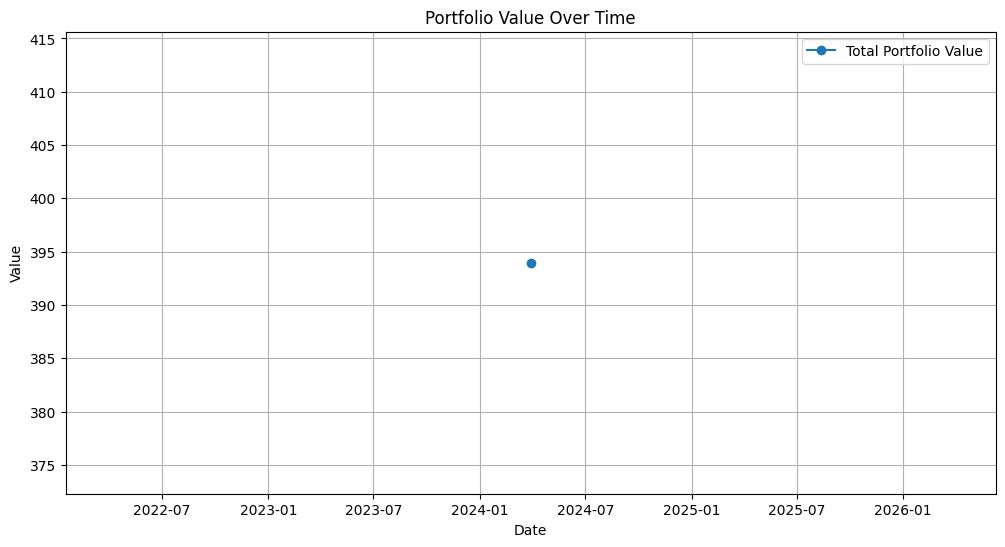

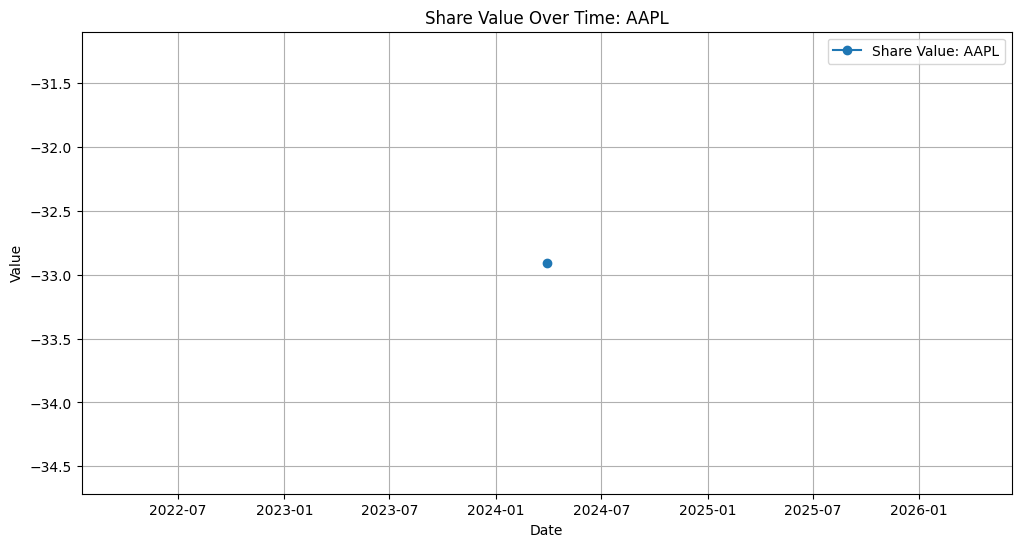

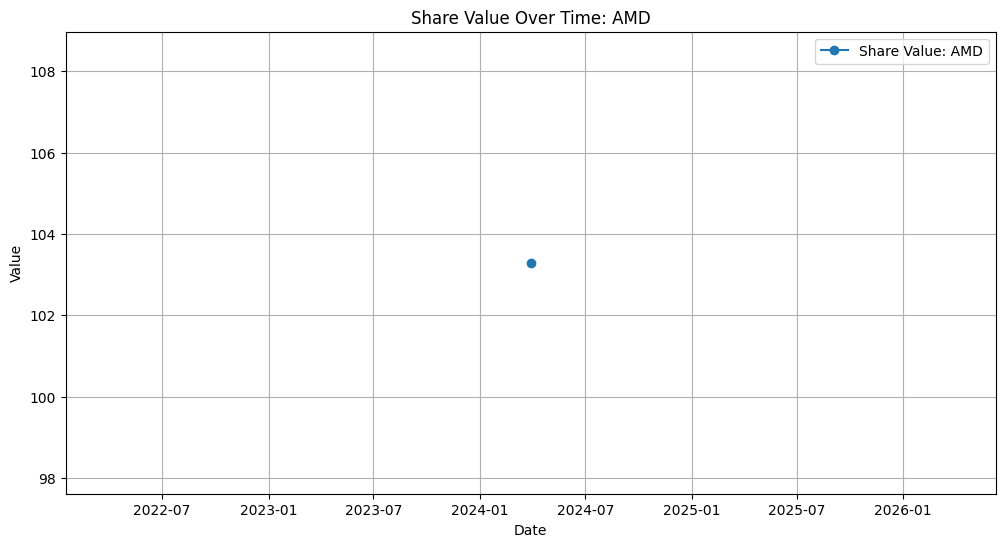

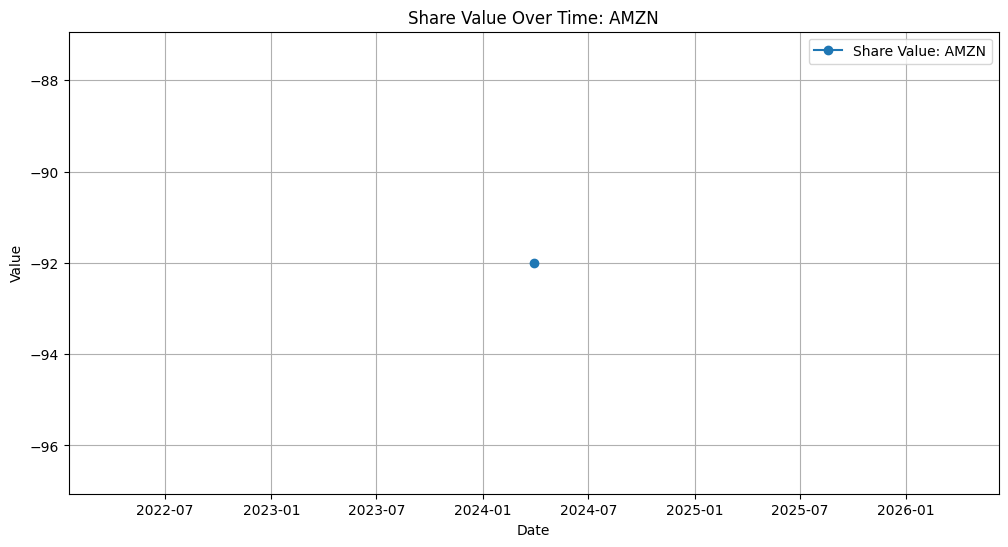

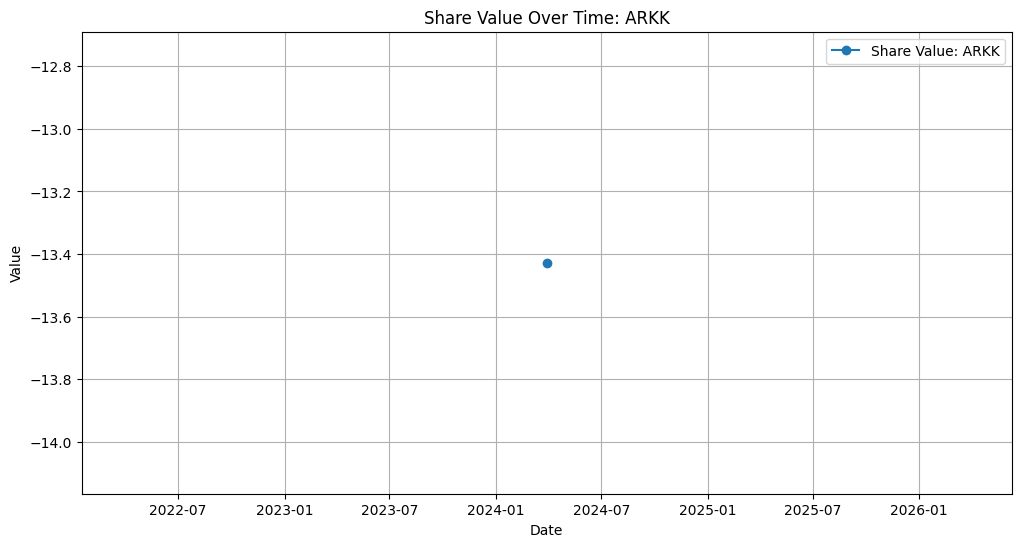

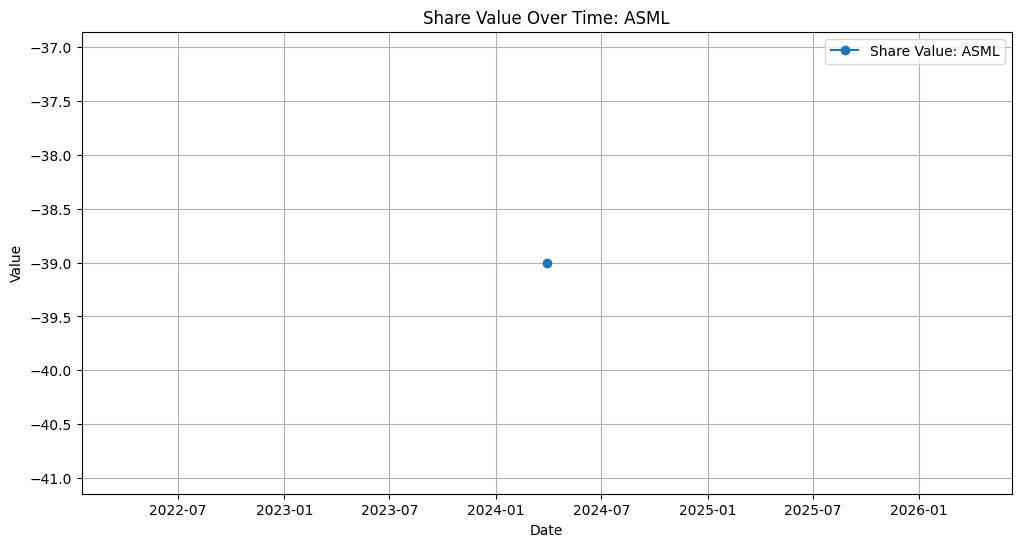

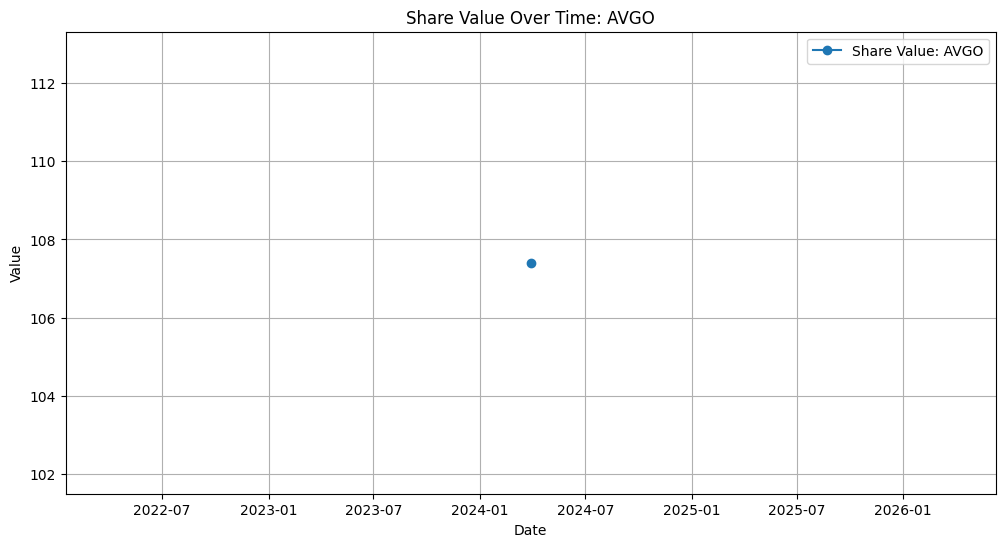

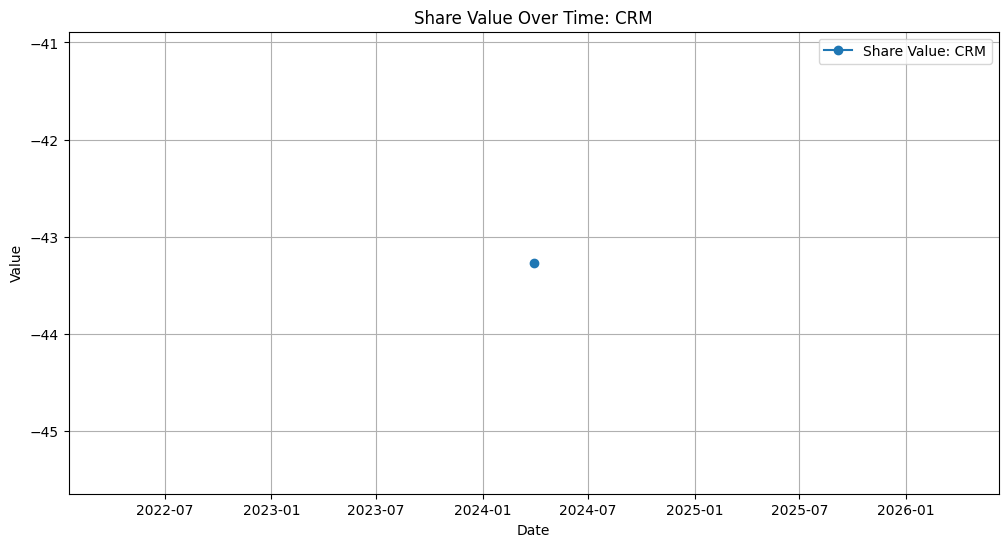

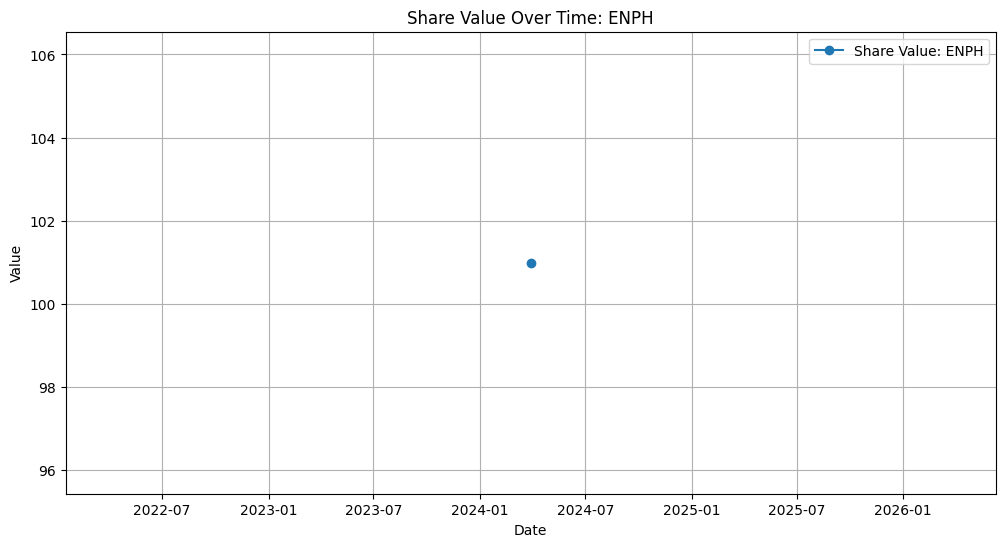

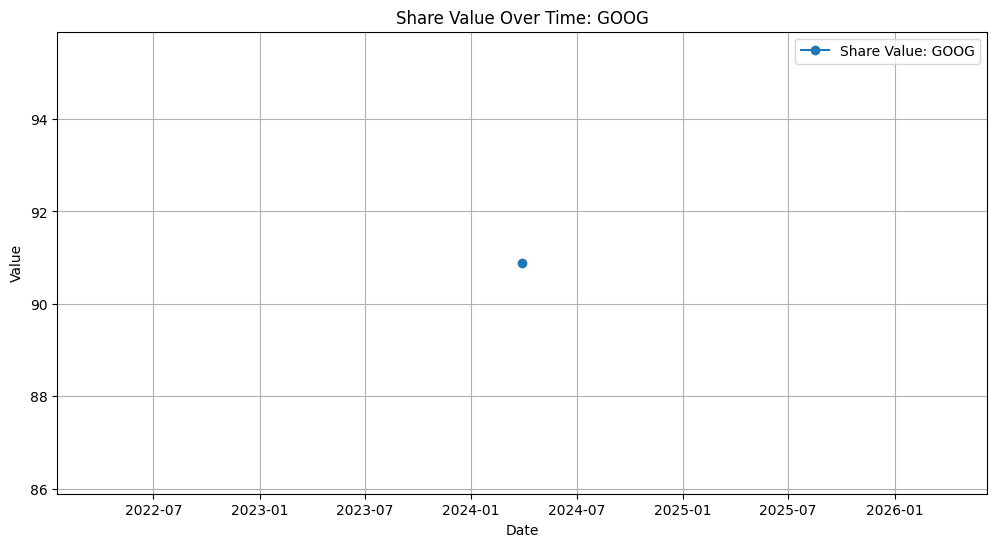

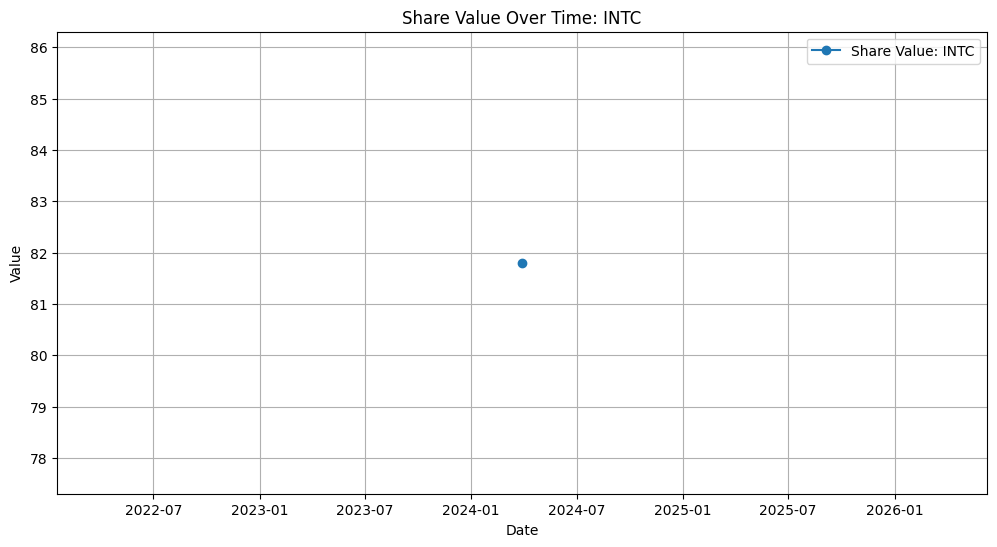

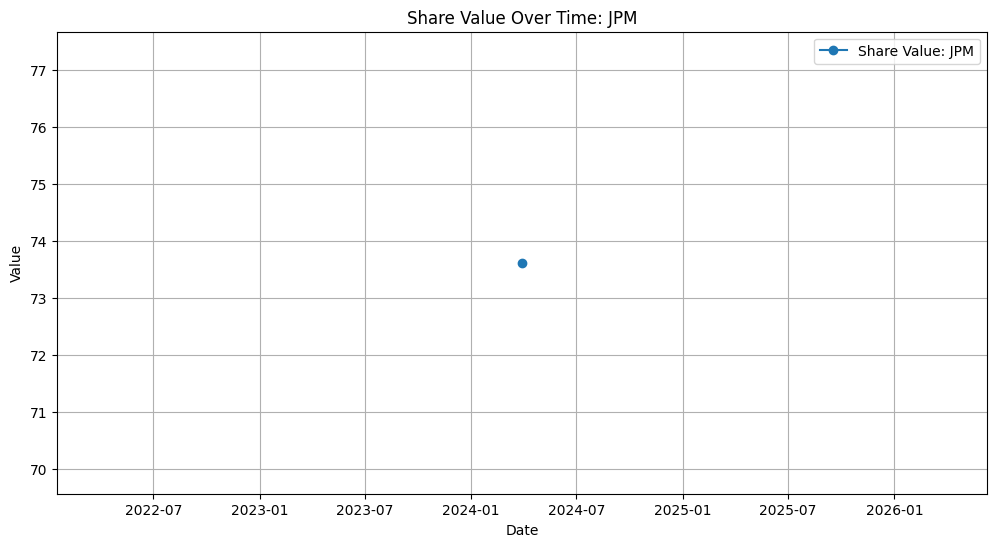

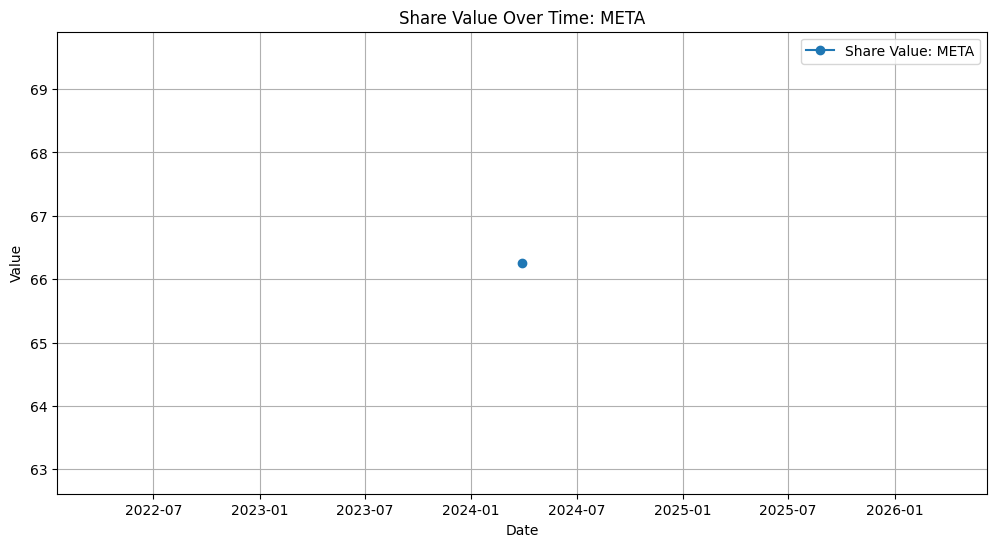

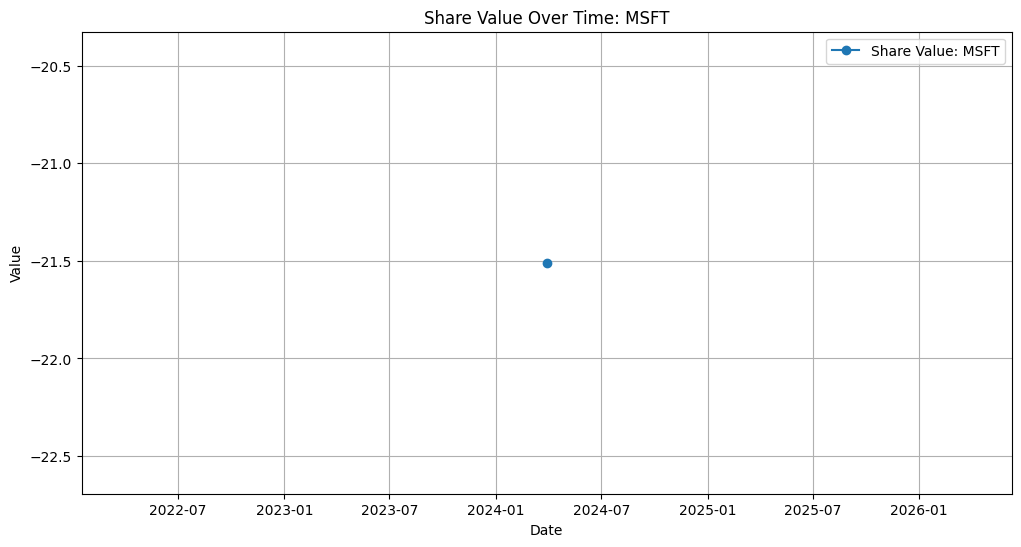

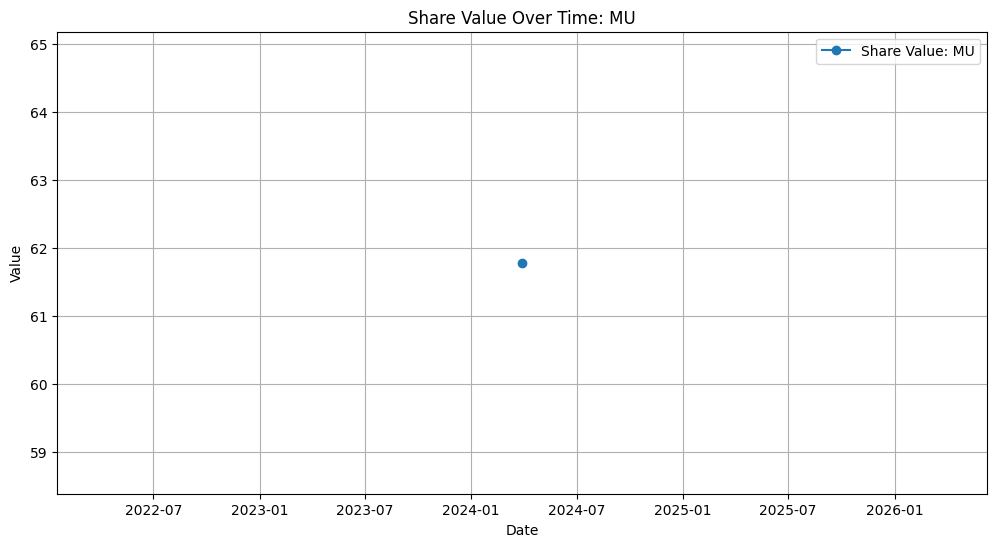

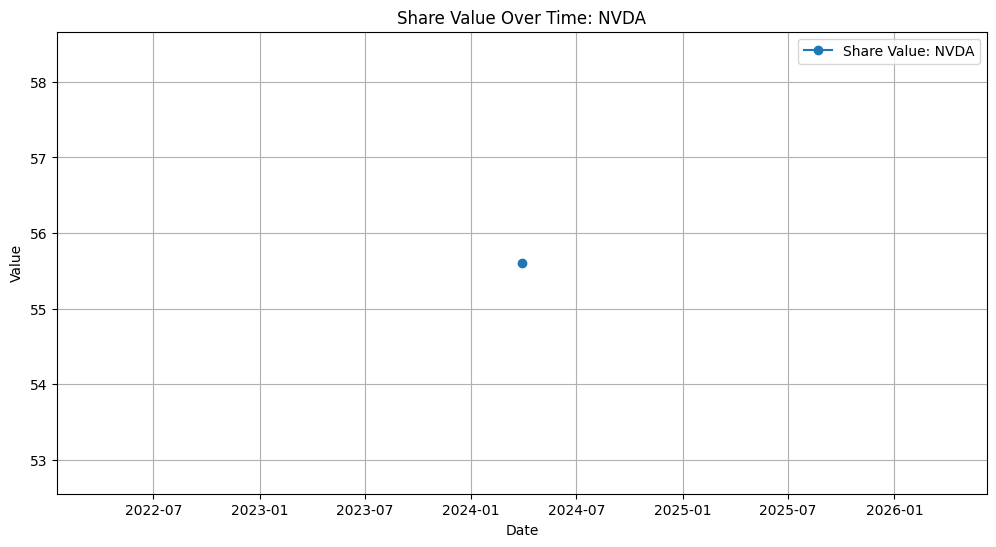

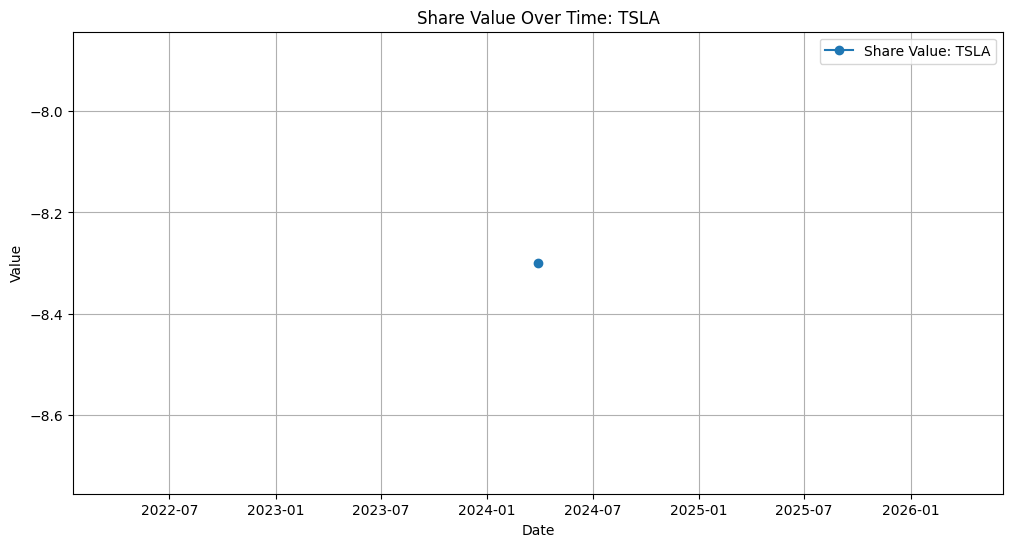

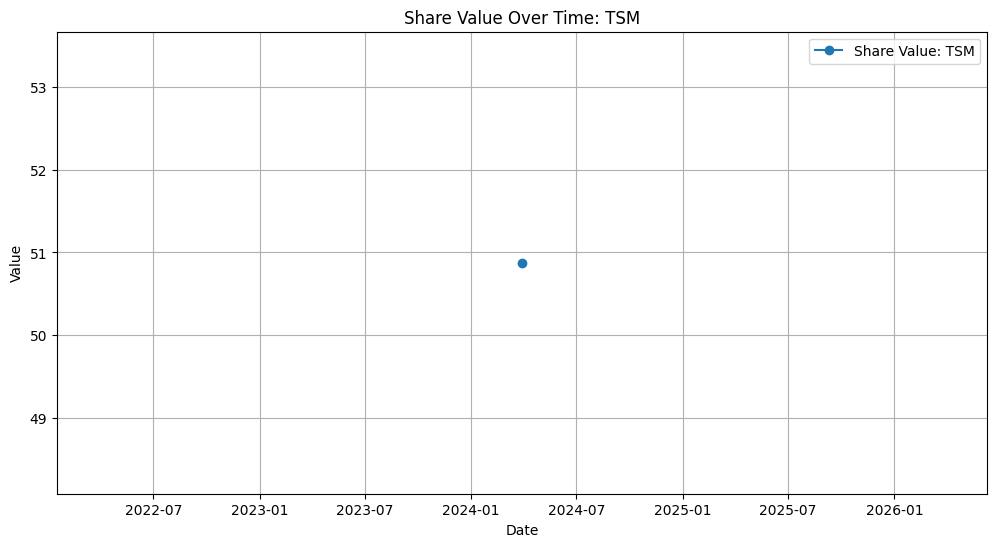

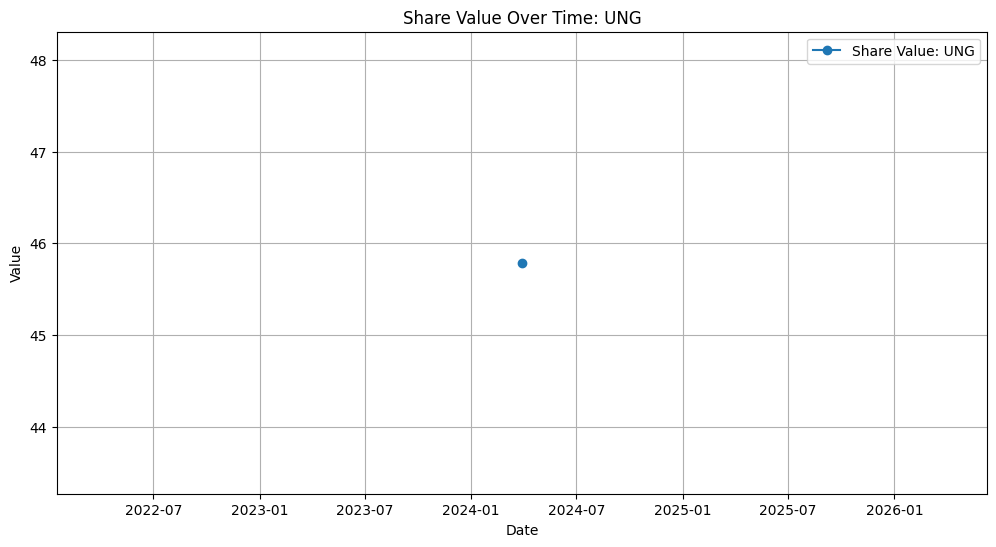

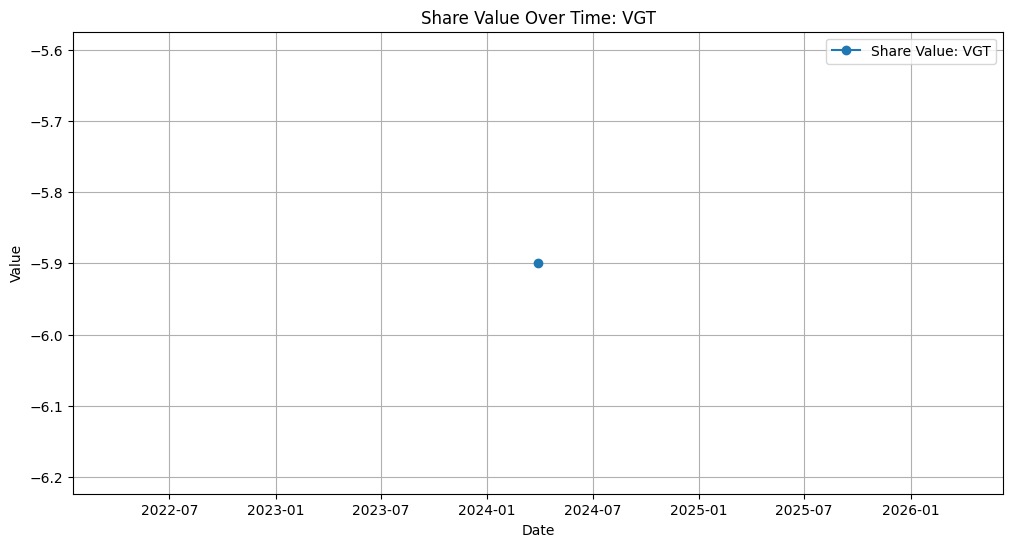

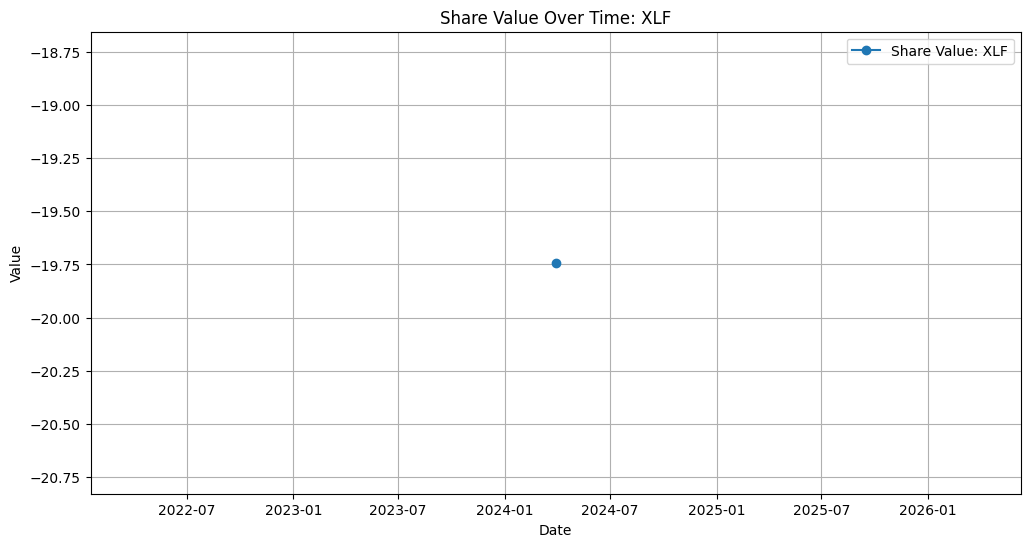

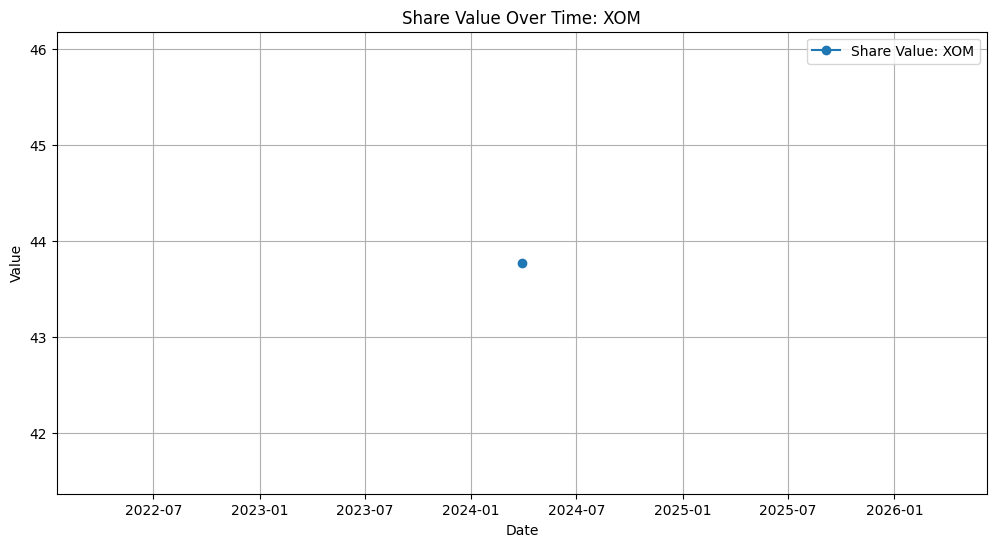

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import json

def display_portfolio_performance():
    """Display the portfolio performance in a table and plot share values."""
    with open('portfolio_performance.json', 'r') as file:
        performance_history = json.load(file)
    
    # Adjusting for potential absence of 'shares_worth'
    normalized_data = []
    for entry in performance_history:
        if 'shares_worth' in entry and isinstance(entry['shares_worth'], str):
            entry['shares_worth'] = json.loads(entry['shares_worth'])
        normalized_data.append(entry)
    
    # Convert to DataFrame
    df_performance = pd.DataFrame(normalized_data)
    df_performance['date'] = pd.to_datetime(df_performance['date'])
    df_performance.set_index('date', inplace=True)
    
    print(df_performance[['portfolio_value']])
    
    # For plotting share values, first ensure 'shares_worth' exists and is correctly formatted
    if 'shares_worth' in df_performance.columns:
        df_shares_worth = pd.json_normalize(df_performance['shares_worth'].dropna())
        df_shares_worth.index = df_performance.dropna(subset=['shares_worth']).index
        
        # Plot the portfolio value
        plt.figure(figsize=(12, 6))
        plt.plot(df_performance.index, df_performance['portfolio_value'], label='Total Portfolio Value', marker='o', linestyle='-')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot each stock's share value over time
        for column in df_shares_worth.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(df_shares_worth.index, df_shares_worth[column], label=f'Share Value: {column}', marker='o', linestyle='-')
            plt.title(f'Share Value Over Time: {column}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

display_portfolio_performance()


In [ ]:
import requests
import pandas as pd
def em_us_real():
    """
    东方财富-美股-实时行情
    http://quote.eastmoney.com/center/gridlist.html#us_stocks
    :return: 美股-实时行情; 延迟 15 min
    "f1": "_",
    "f2": "最新价",
    "f3": "涨跌幅",
    "f4": "涨跌额",
    "f5": "成交量",
    "f6": "成交额",
    "f7": "振幅",
    "f8": "换手率",
    "f9": "-",
    "f10": "_",
    "f11": "_",
    "f12": "简称",
    "f13": "编码",
    "f14": "名称",
    "f15": "最高价",
    "f16": "最低价",
    "f17": "开盘价",
    "f18": "昨收价",
    "f20": "总市值",
    "f21": "_",
    "f22": "_",
    "f23": "_",
    "f24": "_",
    "f25": "_",
    "f26": "_",
    "f33": "_",
    "f62": "_",
    "f115": "市盈率",
    "f124": "时间戳",
    "f128": "_",
    "f140": "_",
    "f141": "_",
    "f136": "_",
    "f152": "_",
    """
    url = "http://72.push2.eastmoney.com/api/qt/clist/get"
    params = {
        "pn": "1",
        "pz": "20000",
        "po": "1",
        "np": "1",
        "ut": "bd1d9ddb04089700cf9c27f6f7426281",
        "fltt": "2",
        "invt": "2",
        "fid": "f3",
        "fs": "m:105,m:106,m:107",
        "fields": "f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f16,f17,f18,f20,f21,"
                  "f23,f24,f25,f26,f22,f33,f11,f62,f128,f136,f115,f124,f152",
        "_": str(int(time.time() * 1000)),
    }
    res = requests.get(url, params=params)
    if res.status_code != 200:
        logging.error(f"em_us_real/status_code:{res.status_code}/text:{res.text}")
        return []
    else:
        try:
            data_json = res.json()
        except Exception as e:
            logging.error(f"em_us_real/error: res.json()/detail:{e.__str__()}")
            return []
        if "data" in data_json and "diff" in data_json["data"] and data_json["data"]["diff"]:
            res = []
            for d in data_json["data"]["diff"]:
                _datetime = mystriptime(d["f124"])
                res.append({"stock_code": d["f12"],
                            "name": d["f14"],
                            "eng_name": d["f12"],
                            "date": _datetime.strftime("%Y-%m-%d"),
                            "time": _datetime.strftime("%H:%M:%M"),
                            "now": pd.to_numeric(d["f2"], errors="coerce"),
                            "open": pd.to_numeric(d["f17"], errors="coerce"),
                            "close": pd.to_numeric(d["f18"], errors="coerce"),
                            "high": pd.to_numeric(d["f15"], errors="coerce"),
                            "low": pd.to_numeric(d["f16"], errors="coerce"),
                            "volume": pd.to_numeric(d["f6"], errors="coerce"),
                            "turnover": pd.to_numeric(d["f5"], errors="coerce"),
                            "buy": pd.to_numeric(d["f2"], errors="coerce"),
                            "sell": pd.to_numeric(d["f2"], errors="coerce"),
                            "change": pd.to_numeric(d["f4"], errors="coerce"),
                            "change_rate": pd.to_numeric(d["f3"], errors="coerce"),
                            "stock_type": "us"})
            return res
        else:
            return []

In [ ]:
def get_us_stock_codes():
    stocks = em_us_real()
    return [{"stock_code": i["stock_code"],
             "name": i["name"],
             "eng_name": i["eng_name"],
             "stock_type": "us"}
            for i in stocks]

In [ ]:
import requests
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/100.0.4896.75 "
        "Safari/537.36"
    )
}
def tencent_us_minute(stock_code, latest_minute=True):
    prefix_code = "us" + stock_code + ".OQ"
    res = requests.get(us_tencent_minute.format(prefix_code), headers=headers)
    if res.status_code != 200:
        logging.error(f"tencent_hk_minute/status_code:{res.status_code}/text:{res.text}")
        return []
    else:
        try:
            data_json = res.json()
        except Exception as e:
            logging.error(f"tencent_hk_minute/error: res.json()/detail:{e.__str__()}")
            return []
        if "data" in data_json \
                and prefix_code in data_json["data"] \
                and "data" in data_json["data"][prefix_code] \
                and "data" in data_json["data"][prefix_code]["data"] \
                and data_json["data"][prefix_code]["data"]["data"]:
            date = data_json["data"][prefix_code]["data"]["date"]
            date = date[:4] + "-" + date[4:6] + "-" + date[6:]
            res = []
            prev = 0
            for d in data_json["data"][prefix_code]["data"]["data"]:
                d = d.split(" ")
                res.append({
                    "datetime": date + " " + d[0][:2] + ":" + d[0][2:] + ":00",
                    "close": float(d[1]),
                    "volume": float(d[2]) - prev,
                    "stock_type": "hk"
                })
                prev = float(d[2]) - prev

            if latest_minute:
                return res[-1]
            else:
                return res
        else:
            return []

In [ ]:
import requests
from py_mini_racer import py_mini_racer
us_sina_stock_hist_qfq_url = "https://finance.sina.com.cn/us_stock/company/reinstatement/{}_qfq.js"
us_tencent_daily = "http://web.ifzq.gtimg.cn/appstock/app/fqkline/get?_var=kline_dayqfq&param={},day,,,{},qfq"
def sina_us_daily(symbol, adjust=""):
    url = f"https://finance.sina.com.cn/staticdata/us/{symbol}"
    res = requests.get(url)
    js_code = py_mini_racer.MiniRacer()
    js_code.eval(zh_js_decode)
    dict_list = js_code.call(
        "d", res.text.split("=")[1].split(";")[0].replace('"', "")
    )  # 执行js解密代码
    if adjust == "qfq":
        # 使用前复权
        res = requests.get(us_sina_stock_hist_qfq_url.format(symbol))
        try:
            qfq = json.loads(res.text.split("=")[1].split("\n")[0])["data"]
            if len(qfq) == 1:
                return dict_list
        except SyntaxError as e:
            return dict_list
        qfq = sorted(map(lambda x: (x["d"], float(x["f"]), float(x["c"])), qfq))
        n = len(qfq)
        qfq_index = 0
        for data_index in range(len(dict_list)):
            while qfq_index + 1 < n and qfq[qfq_index + 1][0] <= dict_list[data_index]["date"][:10]:
                qfq_index += 1
            dict_list[data_index]["high"] *= qfq[qfq_index][1]
            dict_list[data_index]["high"] += qfq[qfq_index][2]
            dict_list[data_index]["low"] *= qfq[qfq_index][1]
            dict_list[data_index]["low"] += qfq[qfq_index][2]
            dict_list[data_index]["open"] *= qfq[qfq_index][1]
            dict_list[data_index]["open"] += qfq[qfq_index][2]
            dict_list[data_index]["close"] *= qfq[qfq_index][1]
            dict_list[data_index]["close"] += qfq[qfq_index][2]
    return dict_list


def tencent_us_daily(symbol, day=0):
    prefix_code = "us" + symbol + ".OQ"
    res = requests.get(us_tencent_daily.format(prefix_code, day), headers=headers)
    if res.status_code != 200:
        logging.error(f"tencent_hk_daily/status_code:{res.status_code}/text:{res.text}")
        return []
    else:
        try:
            data_json = json.loads(res.text.split("=")[1].split("\n")[0])
        except Exception as e:
            logging.error(f"tencent_hk_daily/error: res.json()/detail:{e.__str__()}")
            return []
        if "data" in data_json \
                and prefix_code in data_json["data"] \
                and "day" in data_json["data"][prefix_code]:
            res = []
            for d in data_json["data"][prefix_code]["day"]:
                res.append({
                    "day": d[0],
                    "open": float(d[1]),
                    "close": float(d[2]),
                    "high": float(d[3]),
                    "low": float(d[4]),
                    "volume": float(d[5])
                })
            return res
        else:
            return []

In [ ]:
import requests
import json
from datetime import datetime, timedelta

# Function to fetch AAPL's daily trading data for the last 'n' days
def fetch_aapl_data(days=30):
    symbol = "AAPL"
    # Adjust the URL and parameters according to the actual API endpoint being used
    url = f"http://web.ifzq.gtimg.cn/appstock/app/fqkline/get?_var=kline_dayqfq&param=us{symbol}.OQ,day,,,{days},qfq"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data_json = json.loads(response.text.split("=")[1])
        if "data" in data_json and f"us{symbol}.OQ" in data_json["data"] and "day" in data_json["data"][f"us{symbol}.OQ"]:
            return data_json["data"][f"us{symbol}.OQ"]["day"]
    return []

# Analyze AAPL's data to make trading decisions
def analyze_aapl_data():
    days = 30
    data = fetch_aapl_data(days)
    
    if not data:
        print("No data fetched for AAPL.")
        return
    
    buy_signals = []
    sell_signals = []
    avg_volume = sum([float(day[5]) for day in data[-10:]]) / 10  # Average volume of the last 10 days
    
    for i in range(len(data)):
        day = data[i]
        date = day[0]
        open_price = float(day[1])
        close_price = float(day[2])
        high_price = float(day[3])
        low_price = float(day[4])
        volume = float(day[5])
        
        # Simple trading signal based on price change and volume
        if close_price > open_price and volume > avg_volume:
            buy_signals.append(date)
        elif close_price < open_price and volume > avg_volume:
            sell_signals.append(date)
    
    return buy_signals, sell_signals

# Example usage
buy_signals, sell_signals = analyze_aapl_data()
print("Buy Signals:", buy_signals)
print("Sell Signals:", sell_signals)

Buy Signals: ['2024-03-01', '2024-03-08', '2024-03-14', '2024-03-15', '2024-03-22']
Sell Signals: ['2024-02-29', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-18', '2024-03-21']


In [ ]:
def fetch_stock_data(symbol, days=30):
    url = f"http://web.ifzq.gtimg.cn/appstock/app/fqkline/get?_var=kline_dayqfq&param=us{symbol}.OQ,day,,,{days},qfq"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data_json = json.loads(response.text.split("=")[1])
        if "data" in data_json and f"us{symbol}.OQ" in data_json["data"] and "day" in data_json["data"][f"us{symbol}.OQ"]:
            return data_json["data"][f"us{symbol}.OQ"]["day"]
    return []

def generate_signals(symbol):
    data = fetch_stock_data(symbol, 30)
    buy_signals, sell_signals = [], []
    if not data:
        return buy_signals, sell_signals
    avg_volume = sum([float(day[5]) for day in data[-10:]]) / 10
    for day in data:
        open_price, close_price, volume = float(day[1]), float(day[2]), float(day[5])
        if close_price > open_price and volume > avg_volume:
            buy_signals.append(day[0])
        elif close_price < open_price and volume > avg_volume:
            sell_signals.append(day[0])
    return buy_signals, sell_signals

# Assuming a simplified scenario where we adjust our position entirely based on the latest signal
def adjust_portfolio(initial_budget=100, initial_aapl=30, initial_tsla=70):
    aapl_signals = generate_signals("AAPL")
    tsla_signals = generate_signals("TSLA")
    # Latest signal decision (for simplicity)
    aapl_decision = "buy" if aapl_signals[0][-1] else "sell" if aapl_signals[1][-1] else "hold"
    tsla_decision = "buy" if tsla_signals[0][-1] else "sell" if tsla_signals[1][-1] else "hold"
    
    # Portfolio adjustment logic (very simplified for the sake of example)
    if aapl_decision == "buy":
        # Allocate more to AAPL, for example, 10% more of the total budget
        initial_aapl += 0.1 * initial_budget
    elif aapl_decision == "sell":
        # Reduce AAPL position by 10%
        initial_aapl -= 0.1 * initial_budget

    if tsla_decision == "buy":
        initial_tsla += 0.1 * initial_budget
    elif tsla_decision == "sell":
        initial_tsla -= 0.1 * initial_budget

    # Ensure total does not exceed initial budget (simplistic approach, actual implementation would need to factor in current market values)
    total_investment = initial_aapl + initial_tsla
    if total_investment > initial_budget:
        over_investment = total_investment - initial_budget
        # Adjust proportionally
        initial_aapl -= (initial_aapl / total_investment) * over_investment
        initial_tsla -= (initial_tsla / total_investment) * over_investment

    return initial_aapl, initial_tsla

# Execute the strategy
aapl_investment, tsla_investment = adjust_portfolio()
print(f"Adjusted AAPL Investment: ${aapl_investment:.2f}")
print(f"Adjusted TSLA Investment: ${tsla_investment:.2f}")


Adjusted AAPL Investment: $33.33
Adjusted TSLA Investment: $66.67
